In [1]:
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_colwidth',1024)

drive_path = '/content/drive/MyDrive/01_Applied_AI_Course_New/CaseStudies/Text Creation/'

# All the News

## Data loading

In [244]:
# connect to all_the_news.db
all_the_news_db = drive_path+'data/all-the-news.db'
conn = sqlite3.connect(all_the_news_db)

In [245]:
# display the schema of tables under db
tables = pd.read_sql_query("SELECT NAME AS 'Table_Name' FROM sqlite_master WHERE type='table'",conn)
tables = tables["Table_Name"].values.tolist()
query = "PRAGMA TABLE_INFO({})".format(tables[0])
print("Schema of",tables[0])
schema = pd.read_sql_query(query,conn)
display(schema)
print()

Schema of longform


,cid,name,type,notnull,dflt_value,pk
0,0,id,,0,None,1
1,1,title,text,0,None,0
2,2,author,text,0,None,0
3,3,date,text,0,None,0
4,4,content,text,0,None,0
5,5,year,integer,0,None,0
6,6,month,integer,0,None,0
7,7,publication,text,0,None,0
8,8,category,text,0,None,0
9,9,digital,integer,0,None,0


In [246]:
# load the table to pandas dataframe for further analysis
longform_df = pd.read_sql_query("select * from longform", conn)
print(longform_df.shape)
longform_df.head()

(204135, 12)


,id,title,author,date,content,year,month,publication,category,digital,section,url
0,1,"Agent Cooper in Twin Peaks is the audience: once delighted, now disintegrating",\nTasha Robinson\n,2017-05-31,"And never more so than in Showtime’s new series revival Some spoilers ahead through episode 4 of season 3 of Twin Peaks. On May 21st, Showtime brought back David Lynch’s groundbreaking TV series Twin Peaks, and fulfilled a prophecy in the process. In the second season finale, back in 1991, the spirit of series-defining murder victim Laura Palmer told FBI special agent and series protagonist Dale Cooper, “I’ll see you again in 25 years.” That clip plays again in the first episode of Lynch’s Twin Peaks revival, as a reminder that decades have in fact gone by, Laura’s promise has been carried out, and a series canceled mid-story is back on the air.A lot has changed in 25 years. The original cast members, who are mostly back on board, have all aged heavily and visibly. Many of the characters have moved on in life, getting new jobs, forming families, or taking up new obsessions. But in the opening episode, Dale Cooper was still where the show left him in 1991: trapped in the spirit domain known as the Bl...",2017,5,Verge,Longform,1.0,None,None
1,2,"AI, the humanity!",\nSam Byford\n,2017-05-30,"AlphaGo’s victory isn’t a defeat for humans — it’s an opportunity A loss for humanity! Man succumbs to machine! If you heard about AlphaGo’s latest exploits last week — crushing the world’s best Go player and confirming that artificial intelligence had mastered the ancient Chinese board game — you may have heard the news delivered in doomsday terms.There was a certain melancholy to Ke Jie’s capitulation, to be sure. The 19-year-old Chinese prodigy declared he would never lose to an AI following AlphaGo’s earthshaking victory over Lee Se-dol last year. To see him onstage last week, nearly bent double over the Go board and fidgeting with his hair, was to see a man comprehensively put in his place.But focusing on that would miss the point. DeepMind, the Google-owned company that developed AlphaGo, isn’t attempting to crush humanity — after all, the company is made up of humans itself. AlphaGo represents a major human achievement and the takeaway shouldn’t be that AI is surpassing our abilities, but ins...",2017,5,Verge,Longform,1.0,None,None
2,3,The Viral Machine,\nKaitlyn Tiffany\n,2017-05-25,"Super Deluxe built a weird internet empire. Can it succeed on TV? When Wolfgang Hammer talks about the future of entertainment, people listen. Hammer is the mastermind behind the American reboot of House of Cards, the guy with the unlikely idea of bringing together David Fincher and a forgotten BBC series. He oversaw two of CBS Films’ first prestige movies: the Coen brothers’ Inside Llewyn Davis and Martin McDonagh’s Seven Psychopaths. He’s had a charmed career: leap-frogging from a master’s degree at Stanford to an entry-level job at Media Rights Capital to eventually becoming the president of CBS’s fledgling films division. So when Hammer came to Turner with an ambitious concept, the cable giant was willing to entertain it. Turner owns TBS, TNT, CNN, and Cartoon Network, but what Hammer was proposing was something altogether different: an all-in-one production company that would thrive online and pretty much do whatever it wanted. Now 18 months old, Super Deluxe is being nurtured with a reliable b...",2017,5,Verge,Longform,1.0,None,None
3,4,How Anker is beating Apple and Samsung at their own accessory game,\nNick Statt\n,2017-05-22,"Steven Yang quit his job at Google in the summer of 2011 to build the products he felt the world needed: a line of reasonably priced accessories that would be better than the ones you could buy from Apple and other big-name brands. These accessories — batteries, cables, chargers — would solve our most persistent gadget problem by letting us stay powered on at all times. There were just a few problems: Yang knew nothing about start

## Basic EDA

In [256]:
# we are picking only title and content which has text data
longform_text_data = longform_df[['title','content']]
print(longform_text_data.shape)
longform_text_data.head()

(204135, 2)


,title,content
0,"Agent Cooper in Twin Peaks is the audience: once delighted, now disintegrating","And never more so than in Showtime’s new series revival Some spoilers ahead through episode 4 of season 3 of Twin Peaks. On May 21st, Showtime brought back David Lynch’s groundbreaking TV series Twin Peaks, and fulfilled a prophecy in the process. In the second season finale, back in 1991, the spirit of series-defining murder victim Laura Palmer told FBI special agent and series protagonist Dale Cooper, “I’ll see you again in 25 years.” That clip plays again in the first episode of Lynch’s Twin Peaks revival, as a reminder that decades have in fact gone by, Laura’s promise has been carried out, and a series canceled mid-story is back on the air.A lot has changed in 25 years. The original cast members, who are mostly back on board, have all aged heavily and visibly. Many of the characters have moved on in life, getting new jobs, forming families, or taking up new obsessions. But in the opening episode, Dale Cooper was still where the show left him in 1991: trapped in the spirit domain known as the Bl..."
1,"AI, the humanity!","AlphaGo’s victory isn’t a defeat for humans — it’s an opportunity A loss for humanity! Man succumbs to machine! If you heard about AlphaGo’s latest exploits last week — crushing the world’s best Go player and confirming that artificial intelligence had mastered the ancient Chinese board game — you may have heard the news delivered in doomsday terms.There was a certain melancholy to Ke Jie’s capitulation, to be sure. The 19-year-old Chinese prodigy declared he would never lose to an AI following AlphaGo’s earthshaking victory over Lee Se-dol last year. To see him onstage last week, nearly bent double over the Go board and fidgeting with his hair, was to see a man comprehensively put in his place.But focusing on that would miss the point. DeepMind, the Google-owned company that developed AlphaGo, isn’t attempting to crush humanity — after all, the company is made up of humans itself. AlphaGo represents a major human achievement and the takeaway shouldn’t be that AI is surpassing our abilities, but ins..."
2,The Viral Machine,"Super Deluxe built a weird internet empire. Can it succeed on TV? When Wolfgang Hammer talks about the future of entertainment, people listen. Hammer is the mastermind behind the American reboot of House of Cards, the guy with the unlikely idea of bringing together David Fincher and a forgotten BBC series. He oversaw two of CBS Films’ first prestige movies: the Coen brothers’ Inside Llewyn Davis and Martin McDonagh’s Seven Psychopaths. He’s had a charmed career: leap-frogging from a master’s degree at Stanford to an entry-level job at Media Rights Capital to eventually becoming the president of CBS’s fledgling films division. So when Hammer came to Turner with an ambitious concept, the cable giant was willing to entertain it. Turner owns TBS, TNT, CNN, and Cartoon Network, but what Hammer was proposing was something altogether different: an all-in-one production company that would thrive online and pretty much do whatever it wanted. Now 18 months old, Super Deluxe is being nurtured with a reliable b..."
3,How Anker is beating Apple and Samsung at their own accessory game,"Steven Yang quit his job at Google in the summer of 2011 to build the products he felt the world needed: a line of reasonably priced accessories that would be better than the ones you could buy from Apple and other big-name brands. These accessories — batteries, cables, chargers — would solve our most persistent gadget problem by letting us stay powered on at all times. There were just a few problems: Yang knew nothing about starting a company, building consumer electronics, or selling products. “I was a software engineer all my life at Google. I didn’t know anyone in the electronics manufacturing world,” Yang tells me over Skype from his office in Shenzhen, China. But he started the company regardless, thanks in no smal

In [257]:
# check for duplicate titles & content
print('Duplicate Titles :: ',longform_text_data[longform_text_data.title.duplicated()].shape[0])
print('Duplicate Content :: ',longform_text_data[longform_text_data.content.duplicated()].shape[0])
print('Duplicate of both Title & Content :: ',longform_text_data[(longform_text_data.title.duplicated()) & (longform_text_data.content.duplicated())].shape[0])
print(' ')
print(' ')

print('Total records Before removing duplicated title & content :: ', longform_text_data.shape[0])
longform_text_data.drop_duplicates(inplace=True)
print('*'*50)
print('Total records After removing duplicated title & content :: ', longform_text_data.shape[0])



Duplicate Titles ::  9325
Duplicate Content ::  26105
Duplicate of both Title & Content ::  7574
 
 
Total records Before removing duplicated title & content ::  204135
**************************************************
Total records After removing duplicated title & content ::  196962


In [262]:
# check for missing title & content
print('Missing Titles :: ',longform_text_data[longform_text_data.title==''].shape[0])
print('Missing Content :: ',longform_text_data[longform_text_data.content.isin(['','[]'])].shape[0])
print('Missing both Title & Content:: ',longform_text_data[(longform_text_data.title=='') & (longform_text_data.content.isin(['','[]']))].shape[0])


Missing Titles ::  3
Missing Content ::  5826
Missing both Title & Content::  1


In [263]:
# remove the record which doesn't have neither title nor content
drop_indexes=longform_text_data[(longform_text_data.title=='') & (longform_text_data.content.isin(['','[]']))].index
longform_text_data.drop(index=drop_indexes,inplace=True)
print('Shape after dorpping empty text data from both title and content is ',longform_text_data.shape)

Shape after dorpping empty text data from both title and content is  (196961, 2)


In [264]:
# get the length of text columns title & content
longform_text_data['title_#_of_words'] = longform_text_data.title.apply(lambda x: len(x.split(' ')) if x !='' else 0)
longform_text_data['content_#_of_words'] = longform_text_data.content.apply(lambda x: len(x.split(' ')) if x!=None else 0)

### Titles

In [265]:
# Basic Stats
print('*'*50)
print('title_#_of_words')
print('*'*25)
print(longform_text_data['title_#_of_words'].describe())
print('*'*50)
print('content_#_of_words')
print('*'*25)
print(longform_text_data['content_#_of_words'].describe())

**************************************************
title_#_of_words
*************************
count    196961.000000
mean         11.028701
std           3.619536
min           0.000000
25%           9.000000
50%          11.000000
75%          14.000000
max          61.000000
Name: title_#_of_words, dtype: float64
**************************************************
content_#_of_words
*************************
count    196961.000000
mean        748.769513
std         801.477214
min           0.000000
25%         296.000000
50%         617.000000
75%        1001.000000
max       50517.000000
Name: content_#_of_words, dtype: float64


In [267]:
total_words_count = sum([len(i[0].split()) for i in longform_text_data.values if i[0]!=None])
print('Total Words Count is',total_words_count)

Total Words Count is 2184593


In [268]:
# check the percentile of the title and content
percentile = {'percent':[], 'title':[], 'content':[]}
for i in range(10, 101, 10):
  percentile['percent'].append(f'{i}%')
  percentile['title'].append(longform_text_data['title_#_of_words'].quantile(i/100))
  percentile['content'].append(longform_text_data['content_#_of_words'].quantile(i/100))

pd.DataFrame(percentile).set_index('percent')

,title,content
percent,,
10%,7.0,26.0
20%,8.0,233.0
30%,9.0,357.0
40%,10.0,488.0
50%,11.0,617.0
60%,12.0,754.0
70%,13.0,908.0
80%,14.0,1111.0
90%,16.0,1436.0


In [269]:
# check the percentile of the title and content
percentile = {'percent':[], 'title':[], 'content':[]}
for i in range(95, 101, 1):
  percentile['percent'].append(f'{i}%')
  percentile['title'].append(longform_text_data['title_#_of_words'].quantile(i/100))
  percentile['content'].append(longform_text_data['content_#_of_words'].quantile(i/100))

pd.DataFrame(percentile).set_index('percent')

,title,content
percent,,
95%,17.0,1825.0
96%,17.0,1974.0
97%,18.0,2211.0
98%,18.0,2598.0
99%,20.0,3445.4
100%,61.0,50517.0


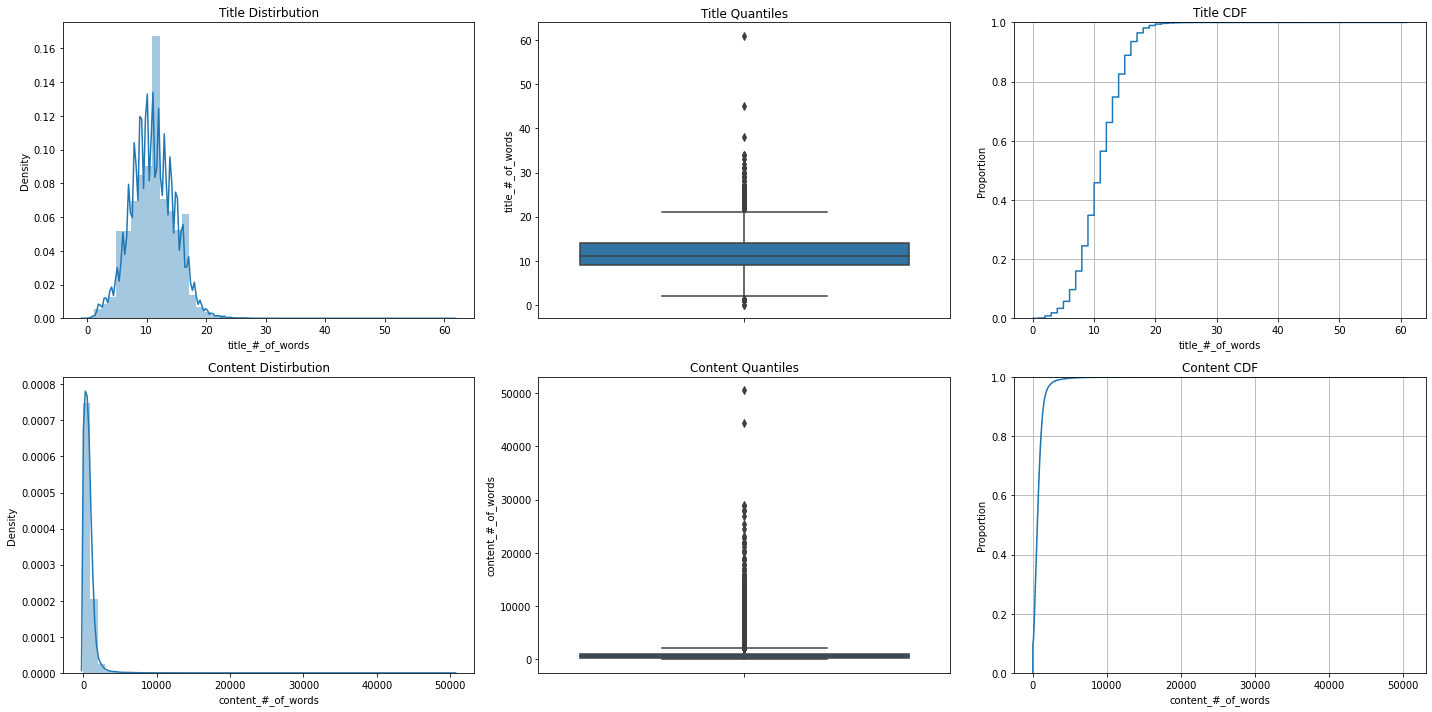

In [270]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
sns.distplot(longform_text_data['title_#_of_words'],ax=axs[0,0])
axs[0,0].title.set_text('Title Distirbution')
sns.boxplot(y=longform_text_data['title_#_of_words'],ax=axs[0,1])
axs[0,1].title.set_text('Title Quantiles')
sns.ecdfplot(longform_text_data['title_#_of_words'],ax=axs[0,2])
axs[0,2].title.set_text('Title CDF')
axs[0,2].grid()


sns.distplot(longform_text_data['content_#_of_words'],ax=axs[1,0])
axs[1,0].title.set_text('Content Distirbution')
sns.boxplot(y=longform_text_data['content_#_of_words'],ax=axs[1,1])
axs[1,1].title.set_text('Content Quantiles')
sns.ecdfplot(longform_text_data['content_#_of_words'],ax=axs[1,2])
axs[1,2].title.set_text('Content CDF')
axs[1,2].grid()


plt.tight_layout()

In [271]:
# combine both the 'title' and 'content' features for further processing
longform_text = pd.DataFrame()
longform_text['longform_text'] = longform_text_data['title']+longform_text_data['content']
longform_text.head()

,longform_text
0,"Agent Cooper in Twin Peaks is the audience: once delighted, now disintegrating And never more so than in Showtime’s new series revival Some spoilers ahead through episode 4 of season 3 of Twin Peaks. On May 21st, Showtime brought back David Lynch’s groundbreaking TV series Twin Peaks, and fulfilled a prophecy in the process. In the second season finale, back in 1991, the spirit of series-defining murder victim Laura Palmer told FBI special agent and series protagonist Dale Cooper, “I’ll see you again in 25 years.” That clip plays again in the first episode of Lynch’s Twin Peaks revival, as a reminder that decades have in fact gone by, Laura’s promise has been carried out, and a series canceled mid-story is back on the air.A lot has changed in 25 years. The original cast members, who are mostly back on board, have all aged heavily and visibly. Many of the characters have moved on in life, getting new jobs, forming families, or taking up new obsessions. But in the opening episode, Dale Cooper was still..."
1,"AI, the humanity! AlphaGo’s victory isn’t a defeat for humans — it’s an opportunity A loss for humanity! Man succumbs to machine! If you heard about AlphaGo’s latest exploits last week — crushing the world’s best Go player and confirming that artificial intelligence had mastered the ancient Chinese board game — you may have heard the news delivered in doomsday terms.There was a certain melancholy to Ke Jie’s capitulation, to be sure. The 19-year-old Chinese prodigy declared he would never lose to an AI following AlphaGo’s earthshaking victory over Lee Se-dol last year. To see him onstage last week, nearly bent double over the Go board and fidgeting with his hair, was to see a man comprehensively put in his place.But focusing on that would miss the point. DeepMind, the Google-owned company that developed AlphaGo, isn’t attempting to crush humanity — after all, the company is made up of humans itself. AlphaGo represents a major human achievement and the takeaway shouldn’t be that AI is surpassing our a..."
2,"The Viral Machine Super Deluxe built a weird internet empire. Can it succeed on TV? When Wolfgang Hammer talks about the future of entertainment, people listen. Hammer is the mastermind behind the American reboot of House of Cards, the guy with the unlikely idea of bringing together David Fincher and a forgotten BBC series. He oversaw two of CBS Films’ first prestige movies: the Coen brothers’ Inside Llewyn Davis and Martin McDonagh’s Seven Psychopaths. He’s had a charmed career: leap-frogging from a master’s degree at Stanford to an entry-level job at Media Rights Capital to eventually becoming the president of CBS’s fledgling films division. So when Hammer came to Turner with an ambitious concept, the cable giant was willing to entertain it. Turner owns TBS, TNT, CNN, and Cartoon Network, but what Hammer was proposing was something altogether different: an all-in-one production company that would thrive online and pretty much do whatever it wanted. Now 18 months old, Super Deluxe is being nurtured ..."
3,"How Anker is beating Apple and Samsung at their own accessory game Steven Yang quit his job at Google in the summer of 2011 to build the products he felt the world needed: a line of reasonably priced accessories that would be better than the ones you could buy from Apple and other big-name brands. These accessories — batteries, cables, chargers — would solve our most persistent gadget problem by letting us stay powered on at all times. There were just a few problems: Yang knew nothing about starting a company, building consumer electronics, or selling products. “I was a software engineer all my life at Google. I didn’t know anyone in the electronics manufacturing world,” Yang tells me over Skype from his office in Shenzhen, China. But he started the company regardless, thanks in no small part to his previous experience with Amazon’s sellers marketplace, a platform for third-party companies and tiny o

In [272]:
# save text data
longform_text.to_parquet(drive_path+'longform_text_data.parquet.gzip', compression='gzip')

**Observations**

1. We choose 'title' and 'content' features which are having text data
2. Total 7574 duplicate data found in both of them, title and content 
3. Only 1 missing data found in both of them, title and content
6. Total records after dropping duplicates and missing were 196961
7. Total words count of complete data is 2184593  
4. 99% of the titles has <=20 words and content has <=3445 words
5. We combine both the 'title' and 'content' features for further processing 


# SciFi Stories

### Data Loading

In [97]:
# read whole text data by chunksize 1024000 and store it into array for further process
SciFi_Stories = drive_path+'data/SciFi_Stories/internet_archive_scifi_v3.txt'

scifi_data = []

with open(SciFi_Stories, 'r') as f:
  while True:
    c = f.read(1024)
    if len(c)>0:
      scifi_data.append(c)
    if not c:
      break

### Basic EDA

#### Combine the split word among the sentences

In [106]:
for idx, val in enumerate(scifi_data):
  if (val[-1]!=' ') & (idx<=len(scifi_data)-2):
    first_sent_split = val.split(' ')
    next_sent_split = scifi_data[idx+1].split(' ')
    word_combine = (''.join([first_sent_split[-1], next_sent_split[0]]))
    #print(word_combine)
    scifi_data[idx] = ' '.join(first_sent_split[:-1] + [word_combine])
    scifi_data[idx+1] = ' '.join(next_sent_split[1:])


In [178]:
print('Total lines using 1024 char len is ', len(scifi_data))
print('Total # of words :: ', sum([len(x.split(' ')) for x in scifi_data]))

Total lines using 1024 char len is  145827
Total # of words ::  26681101


In [114]:
# print first 10 lines of code
for d in scifi_data[:10]:
  print(d)

MARCH # All Stories New and Complete Publisher Editor IF is published bi-monthly by Quinn Publishing Company, Inc., Kingston, New York. Volume #, No. #. Copyright # by Quinn Publishing Company, Inc. Application for Entry' as Second Class matter at Post Office, Buffalo, New York, pending. Subscription # for # issues in U.S. and Possessions: Canada # for # issues; elsewhere #. Aiiow four weeks for change of address. All stories appearing in this magazine are fiction. Any similarity to actual persons is coincidental. #c a fcopy. Printed ia U.S. A. A chat with the editor  i #  science fiction magazine called IF. The title was selected after much thought because of its brevity and on the theory it is indicative of the field and will be easy to remember. The tentative title that just morning and couldn't remember it until we'd had a cup of coffee, it was summarily discarded. A great deal of thought and effort lias gone into the formation of this magazine. We have had the aid of several very 

#### Word count based on CountVectorizer

In [128]:
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer(stop_words='english')
vec.fit(scifi_data)


CountVectorizer(stop_words='english')

In [173]:
list(vec.vocabulary_.items())[:10]

[('march', 119237),
 ('stories', 189210),
 ('new', 131922),
 ('complete', 37120),
 ('publisher', 156325),
 ('editor', 56497),
 ('published', 156323),
 ('bi', 18859),
 ('monthly', 126939),
 ('quinn', 158520)]

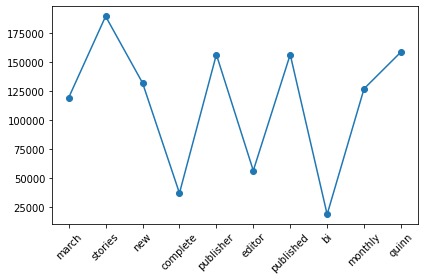

In [177]:
# plotting 10 words count 
plt.plot(list(vec.vocabulary_.keys())[:10], list(vec.vocabulary_.values())[:10], marker='o')
plt.xticks(rotation=45)
plt.tight_layout()

**Observations**
1. Data is in single text file
2. After reading data by 1024 char len got **145827** lines 
3. Total words count of complete text file is **26681101**

# Cornell Movie Dialogs

We construct the corpus using last column of movie_conversations.txt, list of the utterances that make the conversation, in chronological order:['LId1','LId2','LId3'] has to be matched with movie_lines.txt to reconstruct the actual content


## Data Loading

In [276]:
cornell_movie_dialogs_corpus = drive_path+'data/cornell_movie_dialogs_corpus/'

# mapping the line id with text of utterance 
movie_lines_dict = {}

with open(cornell_movie_dialogs_corpus+'movie_lines.txt', encoding='utf-8', errors='ignore') as f:
  for line in f.readlines():
    lineID, characterID, movieID, character_name, text_of_the_utterance = line.split('+++$+++')
    if text_of_the_utterance.strip() != '':
      movie_lines_dict[lineID.rstrip()]= text_of_the_utterance.strip() 
    
# mapping the list of utterancec with movie_lines_dict data 

actual_content = []

with open(cornell_movie_dialogs_corpus+'movie_conversations.txt', encoding='utf-8', errors='ignore') as f:
  for line in f.readlines():
    lst = line.split('+++$+++')[-1].strip(",']\n[ ").replace("'","").split(',')
    #actual_content.append(lst)
    text = ' '.join([movie_lines_dict.get(lid.lstrip()) for lid in lst if movie_lines_dict.get(lid.lstrip())!=None])
    if text !='':
      actual_content.append(text)

cornell_movie_dialogs = pd.DataFrame({'content':actual_content})

In [277]:
# check for duplicate content
print('Duplicate Content :: ',cornell_movie_dialogs[cornell_movie_dialogs.duplicated()].shape[0])
print(' ')
print('Total records Before removing duplicated content :: ', cornell_movie_dialogs.shape[0])
cornell_movie_dialogs.drop_duplicates(inplace=True)
print('*'*50)
print('Total records After removing duplicated content :: ', cornell_movie_dialogs.shape[0])



Duplicate Content ::  221
 
Total records Before removing duplicated content ::  83079
**************************************************
Total records After removing duplicated content ::  82858


In [282]:
cornell_movie_dialogs['word_count']=cornell_movie_dialogs.content.apply(lambda x: len(x.split(' ')))

In [283]:
# Basic Stats
print('*'*50)
print('content word_count')
print('*'*25)
print(cornell_movie_dialogs['word_count'].describe())

**************************************************
content word_count
*************************
count    82858.000000
mean        39.833534
std         44.525329
min          1.000000
25%         14.000000
50%         26.000000
75%         48.000000
max       1228.000000
Name: word_count, dtype: float64


In [288]:
print('Total Words Count is',sum(cornell_movie_dialogs['word_count'].values))

Total Words Count is 3300527


In [289]:
# check the percentile of content
percentile = {'percent':[], 'content':[]}
for i in range(10, 101, 10):
  percentile['percent'].append(f'{i}%')
  percentile['content'].append(cornell_movie_dialogs['word_count'].quantile(i/100))

pd.DataFrame(percentile).set_index('percent')

,content
percent,
10%,9.0
20%,12.0
30%,16.0
40%,21.0
50%,26.0
60%,33.0
70%,42.0
80%,57.0
90%,85.0


In [290]:
# check the percentile of content
percentile = {'percent':[], 'content':[]}
for i in range(95, 101, 1):
  percentile['percent'].append(f'{i}%')
  percentile['content'].append(cornell_movie_dialogs['word_count'].quantile(i/100))

pd.DataFrame(percentile).set_index('percent')

,content
percent,
95%,118.00
96%,130.00
97%,145.00
98%,171.00
99%,215.43
100%,1228.00


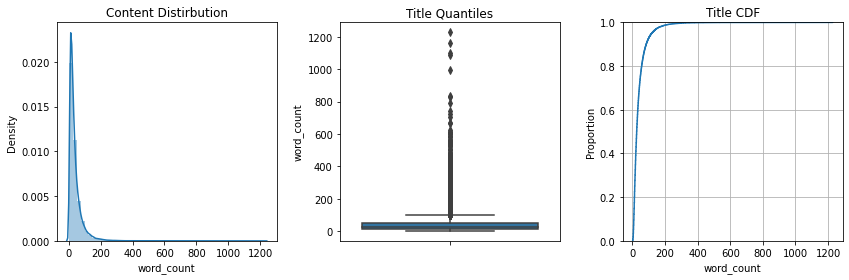

In [291]:
fig, (axs0, axs1, axs2) = plt.subplots(1, 3, figsize=(12, 4))
sns.distplot(cornell_movie_dialogs['word_count'],ax=axs0)
axs0.title.set_text('Content Distirbution')
sns.boxplot(y=cornell_movie_dialogs['word_count'],ax=axs1)
axs1.title.set_text('Title Quantiles')
sns.ecdfplot(cornell_movie_dialogs['word_count'],ax=axs2)
axs2.title.set_text('Title CDF')
axs2.grid()

plt.tight_layout()

In [218]:
# save text data
cornell_movie_dialogs[['content']].to_parquet(drive_path+'cornell_movie_dialogs_text_data.parquet.gzip', compression='gzip')

**Observations**

1. Constructed the actual content using files 'movie_conversations.txt' &  'movie_lines.txt'
2. Total 221 duplicate data found in content 
2. No missing data found
3. Total records after dropping duplicates is 82858 
5. Total words count of complete data is 3300527 
4. 99% of the content has <=215 words
